## Packages

In [1]:
from numpy import dot, conj, matmul, real, diagflat, full, empty, floor, linspace, float64
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
from scipy.linalg import expm
from sympy import Matrix, ImmutableDenseMatrix ,Symbol, symbols, I, diag, eye, lambdify, shape, zeros, rot_axis1,rot_ccw_axis2,rot_axis3
from sympy import E as Exp
from sympy.physics.quantum.dagger import Dagger

## Parameters

In [2]:
#Symbolic Variables

A = Symbol(r"A",real = True,positive = True) #Potential
L = Symbol(r"L",real = True,positive = True) #Distance
E = Symbol(r"E",real = True,positive = True) #Energy

phase14, phase24, phase13 = symbols(r"\delta_{14}, \delta_{24}, \delta_{13}",real = True,positive = True) #Complex phase angles
phases = [phase13,phase14,phase24]

delta21, delta31, delta32, delta41 = symbols(r"\Delta_{21}, \Delta_{31}, \Delta_{32}, \Delta_{41}", real = True, positive = True) #differences in mi**2 between the 3 mass neutrino states
deltas = [delta21,delta31,delta41]

theta12, theta23, theta13, theta14, theta24, theta34 = symbols(r"\theta_{12}, \theta_{23}, \theta_{13}, \theta_{14}, \theta_{24}, \theta_{34}",
                                                               real = True, positive = True) #Mixing angles for 3x3 rotation matrix
thetas = [theta12,theta23,theta13,theta14,theta24,theta34]

#Electron neutrino flavor state
Nu_e = [1,0,0,0]

#Muon neutrino flavor state
Nu_mu = [0,1,0,0]

#Tau neutrino flavor state
Nu_tau = [0,0,1,0]

#Sterile Neutrino flavor state
Nu_s = [0,0,0,1]


# Execution

In [3]:
#Returns:
#Nu_L: Flavor state at distance > step_size
def probability(lam_H:callable,theta_values:list,phase_values:list,mass_values:list,energy_value:float,potential_value:float,step_size:float,Nu_I:list)->list:

    H = lam_H(energy_value,potential_value)
    EVs, EB = eig(H)
    Hd = diagflat(EVs)
    #exponential of the diagonalized hamiltonian    
    eHd = expm(Hd*step_size*(-1j))
    #Inverted Eigenbasis
    EBinv = inv(EB)
    #Converting to exponential of non-diagonalized hamiltonian
    eH = matmul(matmul(EB,  eHd), EBinv)
    #Wavefunction at L > 0
    Nu_L = matmul(eH,Nu_I)

    return Nu_L

In [4]:
#Returns:
#Real(P2) probability of Nu_I beind detected as Nu_F at distance > L
def getdata(lam_H:callable,theta_values:list,phase_values:list,mass_values:list,energy_value:float,potential_value:list,step_size:float,Nu_I:list,Nu_F:list) -> float64:
    i = 0
    Nu_L = Nu_I
    while i < steps:
        Nu_L = probability(lam_H,theta_values,phase_values,mass_values,energy_value,potential_value[i],step_size,Nu_L)
        i+=1
    P = dot(Nu_L,Nu_F)
    Pconj = conj(P)
    P2 = (P*Pconj)
    return real(P2)

In [5]:
#Generates plots of energy vs probability
#Returns:
#None
def probabilityplotter(H:Matrix,theta_values:list,phase_values:list,mass_values:list,energy_values:list,potential_values:list,distance:int,Nu_I:list,Nu_F:list,potential_range:bool=False) -> None:

    lam_H = lambdify([E,A],H)
    Hsize = shape(H)[0]    
    step_size = distance/steps

    #Correction for units
    distance*= 5

    y = []

    Nu_I = Nu_I[0:Hsize]
    Nu_F = Nu_F[0:Hsize]
    
    if not potential_range:
        for EV in energy_values:    
            y.append(getdata(lam_H,theta_values,phase_values,mass_values,EV,full(steps,potential_values),step_size,Nu_I,Nu_F))
    else:
        ylist = empty((len(potential_values),len(energy_values)))
        r = 0
        for EV in energy_values:
            i = 0
            for S in potential_values:
                ylist[i,r] = getdata(lam_H,theta_values,phase_values,mass_values,EV,[S]*steps,step_size,Nu_I,Nu_F)
                i += 1
            r += 1
        y = ylist[int(floor(len(potential_values)/2)),:]
    
    fig, ax = plt.subplots(1,1,figsize = (12,4))
    axs = [ax]

    xlabel = r"$E$"
    ylabel = r"$P$"
    
    if potential_range == True:
        axs[0].plot(energy_values,[y for y in ylist.transpose()])
        potential_range_label = [Astr for Astr in potential_values]
        leg2 = axs[0].legend(potential_range_label,loc = "upper right")
        axs[0].add_artist(leg2)
    else:
        axs[0].plot(energy_values,y)        
      
    axs[0].legend([str(Hsize) + "x" + str(Hsize) + " Hamiltonian"],loc = "upper left")
    
    axs[0].set_xlabel(xlabel+" (GeV)")
    axs[0].set_ylabel(ylabel)
    axs[0].set_title(ylabel + " vs " + xlabel)

In [6]:
#Returns:
#Hamiltonian for mixing matrix U and potential V
def Hamiltonian(U:Matrix,V:Matrix) -> Matrix:
    
    M = diag(0,*deltas[0:shape(U)[0]-1])
    M *= 1/(2*E)
    H = (U*M*Dagger(U))
    H = H-eye(shape(U)[0])*H[0,0] + V

    #Correction for units
    H *= 5
    
    return H

In [7]:
#Returns:
#PMNS matrix for 2x2, 3x3, or 4x4 case, depending on size

#https://en.wikipedia.org/wiki/Pontecorvo%E2%80%93Maki%E2%80%93Nakagawa%E2%80%93Sakata_matrix
def pmns(size: int,constants: dict) -> Matrix:
    
    U = zeros(size,size)
    if size == 2:
        U = (ImmutableDenseMatrix(rot_axis3(constants[theta12])).col_del(2).row_del(2))
    
    elif size == 3:        
        ComplexRot = rot_ccw_axis2(constants[theta13])
        ComplexRot[0,2] *= Exp**(-I*constants[phase13])
        ComplexRot[2,0] *= Exp**(I*constants[phase13])
        U = rot_axis1(constants[theta23])*ComplexRot*rot_axis3(constants[theta12])
    else:
        R23 = rot_axis1(constants[theta23]).row_insert(3,zeros(1,3)).col_insert(3,Matrix([0,0,0,1]))

        R12 = rot_axis3(constants[theta12]).row_insert(3,zeros(1,3)).col_insert(3,Matrix([0,0,0,1]))

        R13 = rot_ccw_axis2(constants[theta13]).row_insert(3,zeros(1,3)).col_insert(3,Matrix([0,0,0,1]))
        R13[2,0] *= Exp**(I*constants[phase13])
        R13[0,2] *= Exp**(-I*constants[phase13])

        R34 = rot_axis1(constants[theta34]).row_insert(0,zeros(1,3)).col_insert(0,Matrix([1,0,0,0]))

        R24 = rot_axis1(constants[theta24]).row_insert(2,zeros(1,3)).col_insert(2,Matrix([0,0,1,0]))
        R24[1,3] *= Exp**(-I*constants[phase24])
        R24[3,1] *= Exp**(I*constants[phase24])

        R14 = rot_ccw_axis2(constants[theta14]).row_insert(2,zeros(1,3)).col_insert(2,Matrix([0,0,1,0]))
        R14[3,0] *= Exp**(-I*constants[phase14])
        R14[0,3] *= Exp**(I*constants[phase14])

        U = R34*R24*R14*R23*R13*R12
        
    return U

In [8]:
#Initializes program
#Params:
#V: matrix potential for hamiltonian, should contain one symbol with 0s elsewhere
# theta_values: list of neutrino mixing angles - length must correspond to hamiltonian size
# phase_values: list of complex neutrino mixing angles - length must correspond to hamiltonian size
# mass_values: list of neutrino masses - length must correspond to hamiltonian size
# energy_range: range of energies to plot
# potential_values: list of potentials at different distances: list must have length of distance or 1 with potential_range = False, length of any size for potential_range = True
# distance: total length traveled by neutrino
#Nu_I: Starting neutrino flavor state
#Nu_F: Detected neutrino flavor state
#potential_range: True for plotting results of multiple constant potentials, false for plotting results of one non-constant potential
#Returns:
#None
def start(V:Matrix,theta_values:list,phase_values:list,mass_values:list,energy_range:list,potential_values:list,distance:int,Nu_I:list,Nu_F:list,potential_range:bool =False) -> None:
    
    size = shape(V)[0]
    constants = {}
    for i in range(len(theta_values)):
        if thetas[i]:
            constants[thetas[i]] = theta_values[i]
    
    for i in range(len(phase_values)):
        if phases[i]:
            constants[phases[i]] = phase_values[i]
    
    for i in range(len(mass_values)):
        if deltas[i]:
            constants[deltas[i]] = mass_values[i]
    
    U = pmns(size,constants)
    H = Hamiltonian(U,V)
    for i in range(len(mass_values)):
        H = H.subs(deltas[i],mass_values[i])
    probabilityplotter(H,theta_values,phase_values,mass_values,energy_range,potential_values,distance,Nu_I,Nu_F,potential_range)
    

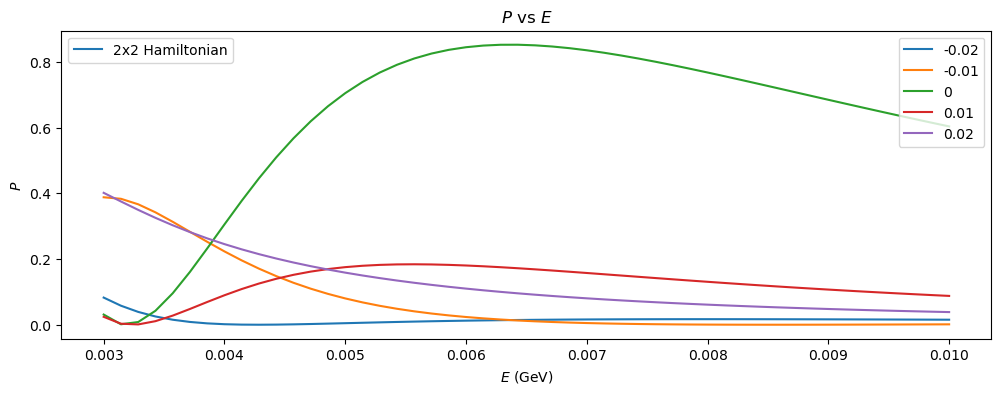

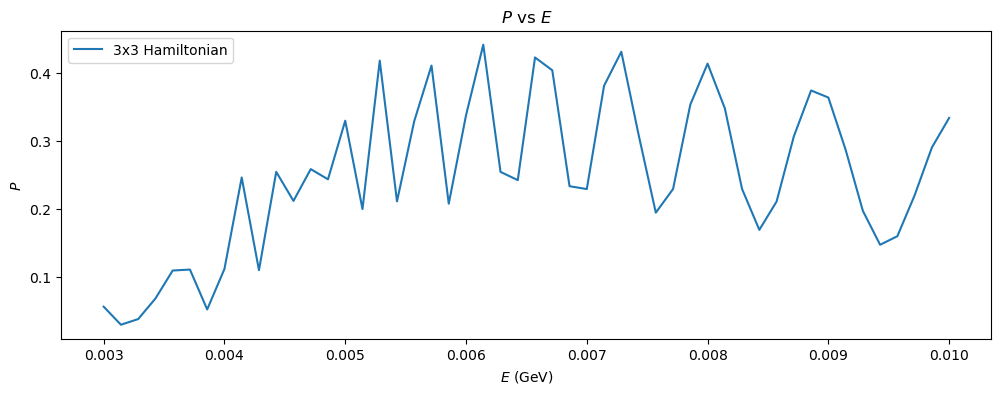

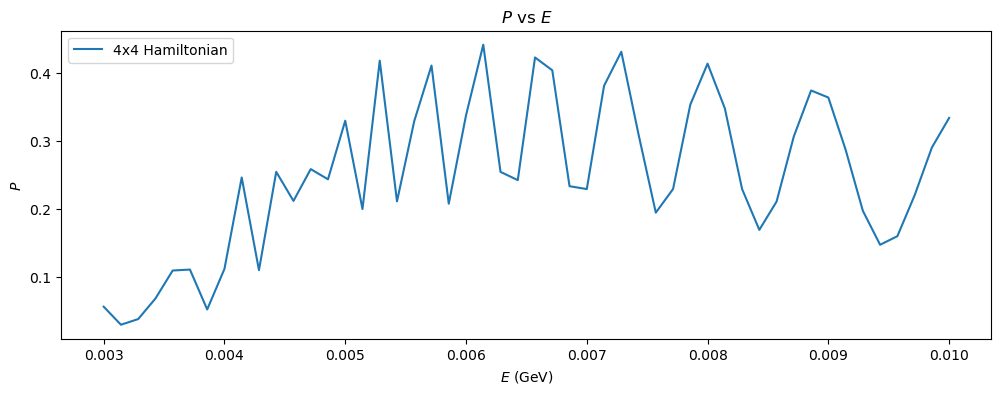

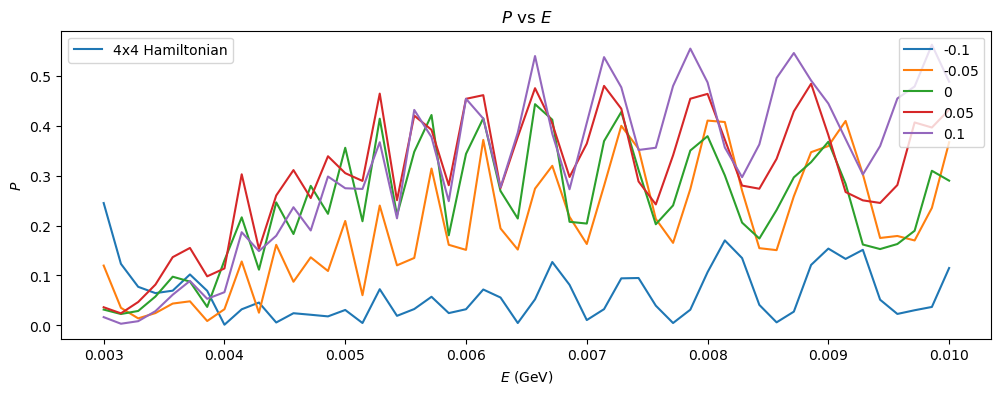

In [9]:
ticks = 50 #How many intervals will energy be divided into

steps = 50 #How many intervals will distance be divided into

distance = 100 #Total distance traveled by Neutrino

#Neutrino mixing angles and masses
#Current estimations can be found on NuFit: http://www.nu-fit.org/?q=node/8
theta12_value = 0.588
theta13_value = 0.149
theta23_value = 0.847

theta14_value = 0.193
theta24_value = 2.99
theta34_value = 2.94

phase14_value = 0.893
phase13_value = 3.09
phase24_value = 1.94

delta21_value = 8*10**(-5)

delta31_value = 2*10**(-3)

delta41_value = 1*10**(-2)

V3 = Matrix([[A,0,0],[0,0,0],[0,0,0]]) #3x3 case with potential only affecting electron neutrino
V4 = Matrix([[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,A]]) #4x4 case with potential only affecting sterile neutrino

#Range of energies to analyze
energy_range = list(linspace(3*10**(-3),10**(-2),num =ticks))


start(Matrix([[A,0],[0,0]]),[theta12_value],[],[delta21_value],energy_range,[-0.02,-0.01,0,0.01,0.02],distance,Nu_mu,Nu_e,potential_range = True)

start(V3,[theta12_value,theta23_value,theta13_value],[phase13_value],[delta21_value,delta31_value],energy_range,[0],distance,Nu_mu,Nu_e)
start(zeros(4,4),[theta12_value,theta23_value,theta13_value,0,0,0],[phase13_value,0,0],[delta21_value,delta31_value,0],energy_range,[0],distance,Nu_mu,Nu_e)

S = 0.05
start(V4,[theta12_value,theta23_value,theta13_value,theta14_value,theta24_value,theta34_value],[phase13_value,phase14_value,phase24_value],[delta21_value,delta31_value,delta41_value],energy_range,[2*-S,-S,0,S,2*S],distance,Nu_mu,Nu_e,potential_range = True)